<a href="https://colab.research.google.com/github/tomollow/Feel-and-Think/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### インポート

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

### データの準備

In [3]:
# Load MNIST data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### モデルのパラメータ設定

In [4]:
# VAE parameters
original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 100
epochs = 5

### エンコーダ

In [5]:
# Encoder
inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

### サンプリング関数

In [6]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = tf.random.normal(shape=(batch_size, latent_dim))
    return z_mean + tf.exp(z_log_sigma / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

### デコーダ

In [7]:
# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

### モデル

In [8]:
# VAE model
vae = Model(inputs, x_decoded_mean)

### VAEの損失関数

In [9]:
# Loss
xent_loss = original_dim * binary_crossentropy(inputs, x_decoded_mean)
kl_loss = - 0.5 * tf.reduce_sum(1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma), axis=-1)
vae_loss = tf.reduce_mean(xent_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

### 学習

In [10]:
# Train the VAE
vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))

Epoch 1/5
600/600 [==============================] - 6s 8ms/step - loss: 197.9000 - val_loss: 171.8598
Epoch 2/5
600/600 [==============================] - 4s 7ms/step - loss: 169.2291 - val_loss: 167.4755
Epoch 3/5
600/600 [==============================] - 5s 8ms/step - loss: 166.3140 - val_loss: 165.5935
Epoch 4/5
600/600 [==============================] - 4s 7ms/step - loss: 164.5156 - val_loss: 163.9866
Epoch 5/5
600/600 [==============================] - 4s 7ms/step - loss: 162.9139 - val_loss: 162.4052


### サンプル生成

1/1 [==============================] - 0s 13ms/step


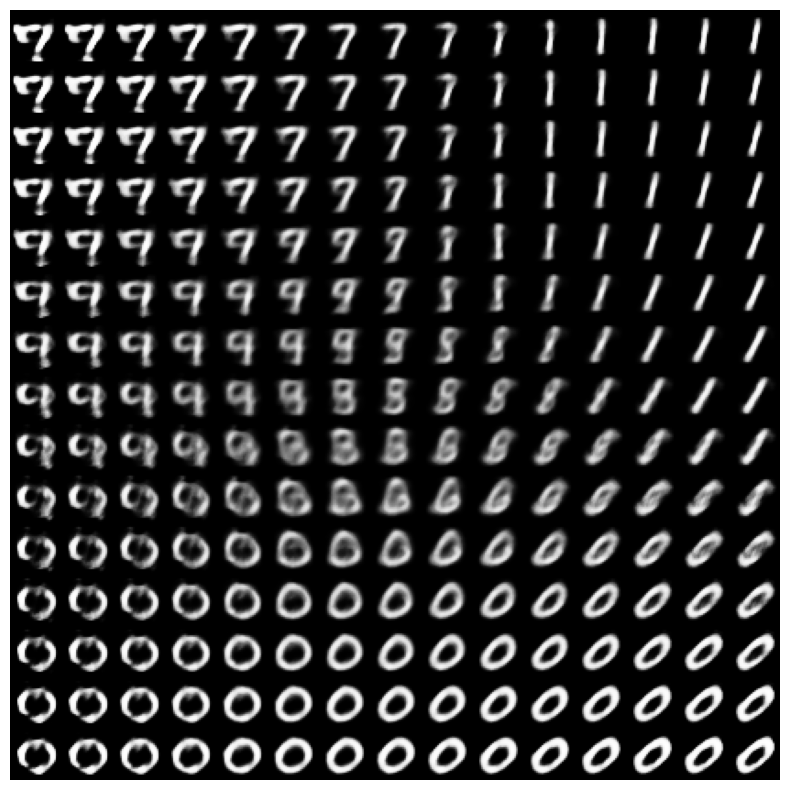

In [11]:
# Generate new samples
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()
